## Load and explore Purkinje locomotion data set

In [37]:
import h5py
import matplotlib.pyplot as plt
import pickle

In [38]:
def Load_Dict_from_HDF5(filename, attrs=False):
    # Modified from: https://codereview.stackexchange.com/questions/120802
    # attrs: (Default False) If True, the routine will also load the attributes of each object.
    #        If "Root", it will only load the attributes of the first file node.

    def recursively_load_dict_contents_from_group(h5file, path, attrs):
        ans = {}
        if len(ans) == 0 and not attrs is False:
            ans["Root Attrs"] = {key:(elem if not isinstance(elem, h5py._hl.base.Empty) else []) for key, elem in dict(h5file['/'].attrs).items()}
            if "oo" in attrs: attrs = False
        for key, item in h5file[path].items():
            if isinstance(item, h5py._hl.dataset.Dataset):
                ans[key] = item[()]
                if attrs: ans["%s_Attrs" % key] = dict(item.attrs)
            elif isinstance(item, h5py._hl.base.Empty):
                ans[key] = []
            elif isinstance(item, h5py._hl.group.Group):
                ans[key] = recursively_load_dict_contents_from_group(h5file, path + key + '/', attrs)
                if attrs: ans[key]["Attrs"] = dict(item.attrs)
        return ans

    with h5py.File(filename, 'r') as h5file:
        return recursively_load_dict_contents_from_group(h5file, '/', attrs)


In [39]:
filename='../data/EncDec_NLT_AddT_spth0-0.h5'
data = Load_Dict_from_HDF5(filename)

In [40]:
data.keys()

dict_keys(['Locomotion Reference', 'Pseudo-Predictions'])

In [41]:
data['Pseudo-Predictions'].keys()

dict_keys(['Cell Names', 'Folder Path', 'Legend matrix', 'Matrix'])

In [42]:
data['Pseudo-Predictions']['Legend matrix']

b"Axis 0: Datapoints\nAxis 1: variables of the pseudo-predictions (0-3: limbs FR-HR-FL-HL terms respectively, 4: nonlinear limb term, 5: sum of all other terms)\nAxis 2: Neurons (lookup table of identity in 'Cell Names')"

4 linear, 1 nonlinear and 1 nuisance component. All components together are the original firing rate of each neuron. We will use the sum of the 1st 5 (i.e. linear and nonliear) components, that is without the nuisance component.

In [43]:
data['Pseudo-Predictions']['Matrix'].shape # time points x features x neurons

(2691968, 6, 105)

In [44]:
data['Locomotion Reference'].keys()

dict_keys(['Phases', 'Pos. X Matrix', 'Wheel Speed'])

In [45]:
data['Locomotion Reference']['Pos. X Matrix'].shape # time points x #limbs

(2691968, 4)

Front right limb movement (x-axis) :

Text(0, 0.5, 'Front right limb position')

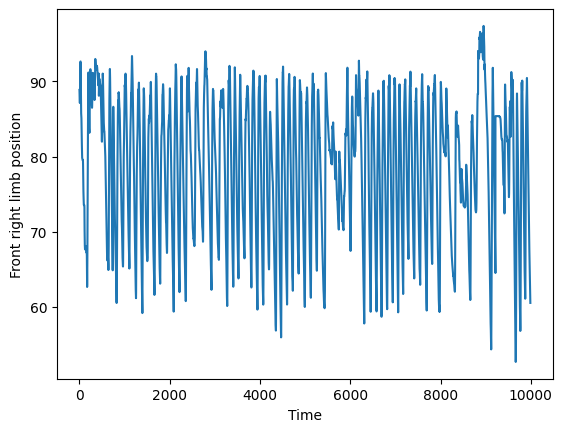

In [46]:
plt.plot(data['Locomotion Reference']['Pos. X Matrix'][10:10000,0])
plt.xlabel('Time')
plt.ylabel('Front right limb position')

Text(0, 0.5, 'Firing rate 1st neuron')

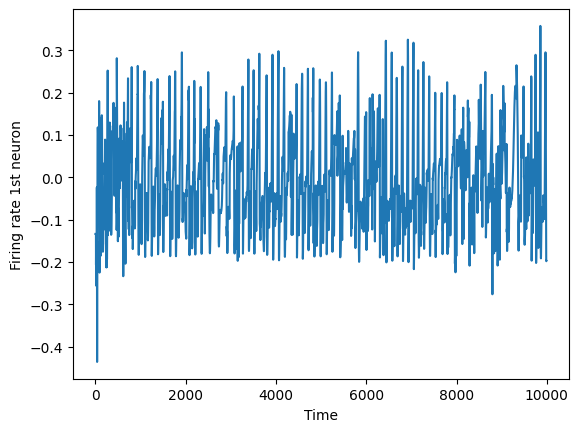

In [47]:
plt.plot(data['Pseudo-Predictions']['Matrix'][10:10000,0:5,0].sum(axis=1))
plt.xlabel('Time')
plt.ylabel('Firing rate 1st neuron')

Firing rate of locomotion is the sum of 1st 5 firing rates (linear and nonlinear). So sum them up. Then Z-score! sRRR from neuronal space to latent (2 dim / 3 dim who knows --- cross validate) to 4 behavioural variables, the x-positions of each limb.

In [48]:
data['Pseudo-Predictions']['Cell Names'][:10]

array([b'MC3808_S1', b'MC3808_S2', b'MC3808_S3', b'MC3808_S4',
       b'MC3808_S5', b'MC3808_S6', b'MC3808_S7', b'MC3810_S10',
       b'MC3810_S11', b'MC3810_S12'], dtype='|S10')

In [50]:
X = data['Pseudo-Predictions']['Matrix'][:,0:5,:].sum(axis=1) # sum linear and nonlinear components of firing rates without nuisance
Y = data['Locomotion Reference']['Pos. X Matrix']
locomotion_names = ['FR','HR','FL','HL']
cell_names = data['Pseudo-Predictions']['Cell Names']
purkinjedata = {'Firing rate':X, 'Locomotion':Y, 'cell_names':cell_names, 'locomotion_names':locomotion_names, 'sampling rate (Hz)': 330}

pickle.dump(purkinjedata, open('../data/purkinje.pickle', 'wb'))

# double check
print('Number of time points: ', X.shape[0])
print('Number of neurons: ', X.shape[1])
print('Number of locomotion features (limbs): ', Y.shape[1])
print('X and Y shapes: ', X.shape, Y.shape)

Number of time points:  2691968
Number of neurons:  105
Number of locomotion features (limbs):  4
X and Y shapes:  (2691968, 105) (2691968, 4)
